In [1]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import optax
from flax.linen.initializers import constant, orthogonal
from typing import Sequence, NamedTuple, Any, Dict
from flax.training.train_state import TrainState
import distrax

from jaxmarl import make
from jaxmarl.wrappers.baselines import SMAXLogWrapper
from jaxmarl.environments.smax import map_name_to_scenario, HeuristicEnemySMAX
from jaxmarl.viz.visualizer import Visualizer, SMAXVisualizer

import functools
from functools import partial
import time
import os
import matplotlib.pyplot as plt

from qdax.core.map_elites import MAPElites
from qdax.core.containers.mapelites_repertoire import compute_cvt_centroids, compute_euclidean_centroids, MapElitesRepertoire
#import qdax.tasks.brax.v1 as environments
#from qdax.tasks.brax.v1.env_creators import scoring_function_brax_envs as scoring_function
from qdax.core.neuroevolution.buffers.buffer import QDTransition
from qdax.core.neuroevolution.networks.networks import MLP
from qdax.core.emitters.mutation_operators import isoline_variation
from qdax.core.emitters.standard_emitters import MixingEmitter
from qdax.utils.plotting import plot_map_elites_results
from qdax.utils.metrics import CSVLogger, default_qd_metrics

from jaxmarl.wrappers.baselines import (
    SMAXLogWrapper,
    MPELogWrapper,
    LogWrapper,
    CTRolloutManager,
)

## Brax version conflict with JaxMARL(0.10.3) and QDax(0.10.4 / 0.12.3)

In [2]:
from typing import Callable, Optional, Tuple
from qdax.custom_types import (
    Descriptor,
    EnvState,
    ExtraScores,
    Fitness,
    Genotype,
    Observation,
    Params,
    RNGKey,
)

In [ ]:
config = {
    # valid for iql, vdn, qmix
    "TOTAL_TIMESTEPS": 1e7,
    "NUM_ENVS": 10, #128, #16,
    "NUM_STEPS": 128,
    "BUFFER_SIZE": 10000, #5000,
    "BUFFER_BATCH_SIZE": 32,
    "HIDDEN_SIZE": 512,
    "MIXER_EMBEDDING_DIM": 16, #64,
    "MIXER_HYPERNET_HIDDEN_DIM": 64, #256,
    "MIXER_INIT_SCALE": 0.001,
    "EPS_START": 1.0,
    "EPS_FINISH": 0.05,
    "EPS_DECAY": 0.1, # percentage of updates
    "MAX_GRAD_NORM": 10,
    "TARGET_UPDATE_INTERVAL": 10,
    "TAU": 1.,
    "NUM_EPOCHS": 8,
    "LR": 0.00005,
    "LEARNING_STARTS": 10000, # timesteps
    "LR_LINEAR_DECAY": False,
    "GAMMA": 0.99,
    "REW_SCALE": 10., # scale the reward to the original scale of SMAC

    # ENV
    "ENV_NAME": "HeuristicEnemySMAX",
    #"MAP_NAME": "3s_vs_5z",
    "MAP_NAME": "2s3z",
    "ENV_KWARGS": {
        "see_enemy_actions": True,
        "walls_cause_death": True,
        "attack_mode": "closest",
    },

    "NUM_SEEDS": 1, # number of vmapped seeds
    "SEED": 0,

    "HYP_TUNE": False, # perform hyp tune

    # evaluate
    "TEST_DURING_TRAINING": True,
    "TEST_INTERVAL": 0.01, #0.05, # as a fraction of updates, i.e. log every 5% of training process
    "TEST_NUM_STEPS": 128,
    "TEST_NUM_ENVS": 512, # number of episodes to average over, can affect performance
}

batch_size = 5 #64# 128 # Num of offsprings 
#env_name = 'walker2d_uni'
episode_length = 128  # NUM_STEPS
num_iterations = int(config["TOTAL_TIMESTEPS"] / (batch_size * config["NUM_ENVS"] * config["NUM_STEPS"])) #610  # TOTAL_TIMESTEPS / (NUM_ENVS × NUM_STEPS)
seed = 88 
policy_hidden_layer_sizes = (128, 128, 128) #(64, 64)
iso_sigma = 0.005 #0.005 
line_sigma = 0.05 #0.05 
num_init_cvt_samples = 2000 #50000 
num_centroids = 100 #1024 
min_descriptor = 0. 
max_descriptor = 1.0 
number_of_descriptors=2

In [4]:
class ScannedRNN(nn.Module):

    @partial(
        nn.scan,
        variable_broadcast="params",
        in_axes=0,
        out_axes=0,
        split_rngs={"params": False},
    )
    @nn.compact
    def __call__(self, carry, x):
        """Applies the module."""
        rnn_state = carry
        ins, resets = x
        hidden_size = ins.shape[-1]
        rnn_state = jnp.where(
            resets[:, np.newaxis],
            self.initialize_carry(hidden_size, *ins.shape[:-1]),
            rnn_state,
        )
        new_rnn_state, y = nn.GRUCell(hidden_size)(rnn_state, ins)
        return new_rnn_state, y

    @staticmethod
    def initialize_carry(hidden_size, *batch_size):
        # Use a dummy key since the default state init fn is just zeros.
        return nn.GRUCell(hidden_size, parent=None).initialize_carry(
            jax.random.PRNGKey(0), (*batch_size, hidden_size)
        )


class RNNQNetwork(nn.Module):
    # homogenous agent for parameters sharing, assumes all agents have same obs and action dim
    action_dim: int
    hidden_dim: int
    init_scale: float = 1.0

    @nn.compact
    def __call__(self, hidden, obs, dones):
        embedding = nn.Dense(
            self.hidden_dim,
            kernel_init=orthogonal(self.init_scale),
            bias_init=constant(0.0),
        )(obs)
        embedding = nn.relu(embedding)

        rnn_in = (embedding, dones)
        hidden, embedding = ScannedRNN()(hidden, rnn_in)

        q_vals = nn.Dense(
            self.action_dim,
            kernel_init=orthogonal(self.init_scale),
            bias_init=constant(0.0),
        )(embedding)

        return hidden, q_vals

In [5]:
def linear_schedule(count):
    frac = (
        1.0
        - (count // (config["NUM_MINIBATCHES"] * config["UPDATE_EPOCHS"]))
        / config["NUM_UPDATES"]
    )
    return config["LR"] * frac

In [6]:
# Init environment
#env = environments.create(env_name, episode_length=episode_length)
scenario = map_name_to_scenario(config["MAP_NAME"])
env = HeuristicEnemySMAX(scenario=scenario, **config["ENV_KWARGS"])
env = SMAXLogWrapper(env)
env = CTRolloutManager(env, batch_size=config["NUM_ENVS"])

rng = jax.random.PRNGKey(config["SEED"])
reset_fn = jax.jit(env.batch_reset)
#reset_fn = jax.jit(env.reset)

config["NUM_ACTORS"] = env.num_agents * config["NUM_ENVS"]
config["NUM_UPDATES"] = (
    config["TOTAL_TIMESTEPS"] // config["NUM_STEPS"] // config["NUM_ENVS"]
)


# Init a random key
key = jax.random.key(seed)

# Init policy network
policy_layer_sizes = policy_hidden_layer_sizes + (env.action_space(env.agents[0]).n,) # Not actually used
#policy_network = ActorRNN(env.action_space(env.agents[0]).n, config=config)
policy_network = RNNQNetwork(
            action_dim=env.max_action_space,
            hidden_dim=config["HIDDEN_SIZE"],
        )

# Init population of controllers
key, subkey = jax.random.split(key)
#keys = jax.random.split(subkey, num=batch_size)
# fake_batch = jnp.zeros(shape=(batch_size, env.observation_size)) # Not needed as on-policy is used for no batches?
# init_variables = jax.vmap(policy_network.init)(keys, fake_batch)
init_x = (
    jnp.zeros(
        (1, 1, env.obs_size)
    ),  # (time_step, batch_size, obs_size)
    jnp.zeros((1, 1)),  # (time_step, batch size)
)
init_hstate = ScannedRNN.initialize_carry(
    config["HIDDEN_SIZE"], 1
)  # (batch_size, hidden_dim)

keys = jax.random.split(subkey, batch_size)
# Assume init_hstate: [H], init_x: [X]
fake_hstate = jnp.stack([init_hstate] * batch_size)  # [N, H]
#fake_x = jnp.stack([init_x] * config["NUM_ENVS"])            # [N, X]
fake_x = tuple(jnp.stack([x] * batch_size) for x in init_x)

#network_params = policy_network.init(subkey, init_hstate, init_x)
network_params = jax.vmap(
    policy_network.init
)(keys, fake_hstate, *fake_x)

In [7]:
class Transition(NamedTuple):
    global_done: jnp.ndarray
    done: jnp.ndarray
    action: jnp.ndarray
    reward: jnp.ndarray
    obs: jnp.ndarray
    env_state: jnp.ndarray
    info: jnp.ndarray
    avail_actions: jnp.ndarray

def batchify(x: dict):
    return jnp.stack([x[agent] for agent in env.agents], axis=0)

def unbatchify(x: jnp.ndarray):
    return {agent: x[i] for i, agent in enumerate(env.agents)}

In [8]:
# Define the function to play a step with the policy in the environment
def play_step_fn(
    runner_state
):
    """
    Play an environment step and return the updated state and the transition.
    """
    #hs, last_obs, last_dones, env_state, rng = carry
    policy_params, env_state, last_obs, last_dones, hstate, rng = runner_state

    rng, rng_a, rng_s = jax.random.split(rng, 3)

    # (num_agents, 1 (dummy time), num_envs, obs_size)
    _obs = batchify(last_obs)[:, np.newaxis]
    _dones = batchify(last_dones)[:, np.newaxis]
    #_obs = batchify_multi(last_obs)[:, :, np.newaxis]    # [batch, num_agents, 1, num_envs, obs_dim]
    #_dones = batchify_multi(last_dones)[:, :, np.newaxis] # [batch, num_agents, 1, num_envs]

    #print("hstate shape:", hstate.shape)  # should be [BATCH_SIZE, NUM_ENVS, NUM_AGENTS, HIDDEN_SIZE]
    #print("_obs shape:", _obs.shape)      # should be [BATCH_SIZE, NUM_ENVS, OBS_DIM]
    #print("_dones shape:", _dones.shape)  # should be [BATCH_SIZE, NUM_ENVS, OBS_DIM]

    new_hstate, q_vals = jax.vmap(
        policy_network.apply, in_axes=(None, 0, 0, 0)
    )(  # vmap across the agent dim
        policy_params,
        hstate,
        _obs,
        _dones,
    )
    #print("new_hstate shape:", new_hstate.shape)  # should be [BATCH_SIZE, NUM_ENVS, NUM_AGENTS, HIDDEN_SIZE]

    q_vals = q_vals.squeeze(
        axis=1
    )  # (num_agents, num_envs, num_actions) remove the time dim

    # explore
    avail_actions = env.get_valid_actions(env_state.env_state)
    avail_actions_batchified = batchify(avail_actions)

    #eps = eps_scheduler(train_state.n_updates)
    #_rngs = jax.random.split(rng_a, env.num_agents)
    #actions = jax.vmap(eps_greedy_exploration, in_axes=(0, 0, None, 0))(
    #    _rngs, q_vals, eps, batchify(avail_actions)
    #)
    
    unavail_actions = 1 - avail_actions_batchified
    q_vals = q_vals - (unavail_actions * 1e10)
    actions_array = jnp.argmax(q_vals, axis=-1)
    actions_dict = unbatchify(actions_array)
    #print("actions", actions_dict)


    new_obs, new_env_state, rewards, dones, infos = env.batch_step(
        rng_s, env_state, actions_dict
    )
    
    rewards = jax.tree.map(lambda x:config.get("REW_SCALE", 1)*x, rewards)

    transition = Transition(
        global_done = jnp.tile(dones["__all__"], env.num_agents),
        done = last_dones,
        action = actions_dict,
        reward = rewards,
        obs = _obs,
        env_state = env_state.env_state.state,
        info = infos,
        avail_actions = avail_actions,
    )

    runner_state = (policy_params, new_env_state, new_obs, dones, new_hstate, rng)
    
    return runner_state, transition

In [9]:
def generate_unroll(
    runner_state,
    episode_length: int,
    play_step_fn: Callable[
        [EnvState, Params, RNGKey],
        Tuple[
            EnvState,
            Params,
            RNGKey,
            Transition,
        ],
    ],
) -> Tuple[EnvState, Transition]:
    """Generates an episode according to the agent's policy, returns the final state of
    the episode and the transitions of the episode.

    Args:
        init_state: first state of the rollout.
        policy_params: params of the individual.
        key: random key for stochasiticity handling.
        episode_length: length of the rollout.
        play_step_fn: function describing how a step need to be taken.

    Returns:
        A new state, the experienced transition.
    """

    def _scan_play_step_fn(
        carry, unused_arg: Any #: Tuple[EnvState, Params, RNGKey]
    ) -> Tuple[Tuple[EnvState, Params, RNGKey], Transition]:
        runner_state, transitions = play_step_fn(carry)
        return runner_state, transitions

    runner_state, transitions = jax.lax.scan(
        _scan_play_step_fn,
        runner_state,
        (),
        length=episode_length,
    )
    return runner_state, transitions


def get_mask_from_transitions(
    data: Transition,
) -> jnp.ndarray:
    is_done = jnp.clip(jnp.cumsum(data.global_done, axis=1), 0, 1)
    mask = jnp.roll(is_done, 1, axis=1)
    mask = mask.at[:, 0].set(0)
    return mask

In [10]:
def scoring_function(
    policy_params: Genotype,
    key: RNGKey,
    episode_length: int,
    play_reset_fn: Callable[[RNGKey], EnvState],
    play_step_fn: Callable[
        [EnvState, Params, RNGKey], Tuple[EnvState, Params, RNGKey, QDTransition]
    ],
    descriptor_extractor: Callable[[QDTransition, jnp.ndarray], Descriptor],
) -> Tuple[Fitness, Descriptor, ExtraScores]:
    """Evaluates policies contained in policies_params in parallel.
    The play_reset_fn function allows for a more general scoring_function that can be
    called with different batch-size and not only with a batch-size of the same
    dimension as init_states.

    To define purely stochastic environments, using the reset function from the
    environment, use "play_reset_fn = env.reset".

    To define purely deterministic environments, as in "scoring_function", generate
    a single init_state using "init_state = env.reset(key)", then use
    "play_reset_fn = lambda key: init_state".

    Args:
        policies_params: The parameters of closed-loop controllers/policies to evaluate.
        key: A jax random key
        episode_length: The maximal rollout length.
        play_reset_fn: The function to reset the environment and obtain initial states.
        play_step_fn: The function to play a step of the environment.
        descriptor_extractor: The function to extract the descriptor.

    Returns:
        fitness: Array of fitnesses of all evaluated policies
        descriptor: Behavioural descriptors of all evaluated policies
        extra_scores: Additional information resulting from the evaluation
    """

    # Reset environments
    key, subkey = jax.random.split(key)
    #keys = jax.random.split(subkey, jax.tree.leaves(policies_params)[0].shape[0])
    #keys = jax.random.split(subkey, config["NUM_ENVS"])
    #init_obs, init_env_state = jax.vmap(play_reset_fn, in_axes=(0,))(keys)
    init_obs, init_env_state = play_reset_fn(key)
    #print("init_obs is a dict with keys:", init_obs.keys())
    #for k, v in init_obs.items():
    #    print(f"init_obs[{k}] shape:", v.shape) 
    
    keys = jax.random.split(subkey, batch_size)

    #init_dones = {
    #    agent: jnp.zeros((config["NUM_ENVS"]), dtype=bool)
    #    for agent in env.agents + ["__all__"]
    #}
    init_hstate = ScannedRNN.initialize_carry(
        config["HIDDEN_SIZE"], len(env.agents), config["NUM_ENVS"]
    )
    
    batched_env_state = jax.tree.map(lambda x: jnp.stack([x] * batch_size), init_env_state)
    batched_obs = jax.tree.map(lambda x: jnp.stack([x] * batch_size), init_obs)
    batched_dones = {
        agent: jnp.stack([jnp.zeros(config["NUM_ENVS"], dtype=bool)] * batch_size)
        for agent in env.agents + ["__all__"]
    }
    batched_hstate = jnp.stack([init_hstate] * batch_size)

    #print("batched_obs is a dict with keys:", batched_obs.keys())
    #for k, v in batched_obs.items():
    #    print(f"batched_obs[{k}] shape:", v.shape) 

    init_runner_state = (policy_params, batched_env_state, batched_obs, batched_dones, batched_hstate, keys)
    #print("init_runner_state:")
    #jax.tree.map(lambda x: print(x.shape), init_runner_state)
    
    # Step environments
    unroll_fn = functools.partial(
        generate_unroll,
        episode_length=episode_length,
        play_step_fn=play_step_fn,
    )
    #keys = jax.random.split(key, jax.tree.leaves(policies_params)[0].shape[0])
    _, data = jax.vmap(unroll_fn)(init_runner_state) # data = Transistions data struc
    #jax.debug.print("after vmap timestep shape: {}", 
    #jax.tree.map(lambda x: x.shape, timestep))

    # Create a mask to extract data properly
    #mask = get_mask_from_transitions(data)
    mask = data.info["returned_episode"]

    # Evaluate
    #print("data.reward shape:", data.reward.shape)
    #print("data.global_done shape:", data.global_done.shape)
    #print("mask shape:", mask.shape)
    
    #print(type(data.infos["returned_episode_returns"]))
    #print(data.infos["returned_episode_returns"].shape)

    # Shape: (num_offspring, episode_len, num_envs, 1)
    returns = data.info["returned_episode_returns"][..., 0]  # (batch_size, episode_length, num_envs)
    #print("returns shape", returns.shape)

    # Take the max over time to extract the one non-zero final return per env
    final_returns = jnp.max(returns, axis=1)  # (batch_size, num_envs)
    #print("final returns shape", final_returns.shape)

    # Average over the environments per offspring
    fitnesses = jnp.mean(final_returns, axis=1, keepdims=True)  # shape: (batch_size, 1)
    descriptors = descriptor_extractor(data, mask)

    #print("fitness shape:", fitnesses.shape)
    #print("descriptors shape:", descriptors.shape)

    return fitnesses, descriptors, {"transitions": data}

In [11]:
def compute_descriptors(data, full_mask):
    """
    Compute per-trajectory descriptors:
    - % of actions that were movement actions over the whole episode (per batch item)
    - Avg ally-ally distance averaged over all steps (per batch item)

    Output: shape (batch_size, 2)
    """
    movement_actions = data.env_state.prev_movement_actions          # (B, T, E, A, 2)
    attack_actions = data.env_state.prev_attack_actions              # (B, T, E, A)
    alive = data.env_state.unit_alive.astype(jnp.float32)            # (B, T, E, A)
    positions = data.env_state.unit_positions                        # (B, T, E, A, 2)
    teams = data.env_state.unit_teams                                # (B, T, E, A)

    is_ally = (teams == 0).astype(jnp.float32)                       # (B, T, E, A)
    ally_alive = alive * is_ally                                     # (B, T, E, A)

    # === Apply mask: ignore masked steps ===
    full_mask = jnp.asarray(full_mask)
    full_mask = 1.0 - full_mask  # Mask where 1 means usable data
    ally_alive = ally_alive * full_mask

    # Movement mask
    moved = jnp.any(movement_actions != 0.0, axis=-1)                # (B, T, E, A)
    moved = moved * ally_alive

    # Attack mask
    attacked = (attack_actions > 0).astype(jnp.float32)
    attacked = attacked * ally_alive

    num_move_actions = jnp.sum(moved, axis=(1, 2, 3))                # (B,)
    num_attack_actions = jnp.sum(attacked, axis=(1, 2, 3))           # (B,)
    total_actions = num_move_actions + num_attack_actions + 1e-8

    movement_pct = num_move_actions / total_actions

    # === Distance computation ===
    def avg_pairwise_distance(pos, mask):
        diffs = pos[:, None, :] - pos[None, :, :]      # (A, A, 2)
        dists = jnp.linalg.norm(diffs, axis=-1)        # (A, A)
        pair_mask = mask[:, None] * mask[None, :]
        not_self = 1 - jnp.eye(mask.shape[0])
        valid_pairs = pair_mask * not_self
        total_dist = jnp.sum(dists * valid_pairs)
        num_pairs = jnp.sum(valid_pairs)
        return jnp.where(num_pairs > 0, total_dist / num_pairs, 0.0)

    ally_mask_full = is_ally * alive * full_mask       # shape (B, T, E, A)

    # (B, T, E)
    all_step_dists = jax.vmap(
        jax.vmap(
            jax.vmap(avg_pairwise_distance, in_axes=(0, 0)),
            in_axes=(0, 0)
        ),
        in_axes=(0, 0)
    )(positions, ally_mask_full)

    avg_dists_over_time = jnp.mean(all_step_dists, axis=(1, 2))

    max_distance = 32
    quarter_max = 0.25 * max_distance
    norm_dist = avg_dists_over_time / quarter_max
    norm_dist = jnp.clip(norm_dist, 0.0, 1.0)

    return jnp.stack([movement_pct, norm_dist], axis=-1)  # shape (B, 2)

def descriptor_extraction_fn(data: Transition, mask: jnp.ndarray) -> Descriptor:
    """Compute trajectory descriptors, with mask expanded to match env_state agent dim."""

    B, T, E, A_total = data.env_state.unit_alive.shape
    A_ally = mask.shape[-1]

    # Expand to match shape of alive/env_state: assume allies are first
    full_mask = jnp.zeros((B, T, E, A_total))
    full_mask = full_mask.at[..., :A_ally].set(mask)

    # Call descriptor computation with full mask
    descriptors = compute_descriptors(data, full_mask)

    return descriptors


In [12]:
def compute_descriptors_old(data):
    """Compute useful descriptors from the state:
    - % of units that moved last step
    - Avg ally-ally distance
    - Avg enemy-enemy distance
    - Avg ally-enemy distance
    """
    #print("Got state of type:", type(state))
    #print("State attributes:", dir(state))  # See what's actually in it
    alive = data.env_state.unit_alive.astype(jnp.float32)           # [num_units]
    positions = data.env_state.unit_positions                       # [num_units, 2]
    teams = data.env_state.unit_teams                               # [num_units], e.g. 0 = ally, 1 = enemy
    movement_actions = data.env_state.prev_movement_actions
    attack_actions = data.env_state.prev_attack_actions
    
    print("movement_actions.shape:", movement_actions.shape)
    _, _, _, A, _ = movement_actions.shape

    print("movement_actions.shape:", movement_actions.shape)
    print("attack_actions.shape:", attack_actions.shape)
    print("alive.shape:", alive.shape)
    # Reshape actions from (128, 640) to (128, 10, 64)
    #discrete_actions = jnp.argmax(actions, axis=-1)  # (128, 10)
    
    movement_actions_mask = movement_actions != -1
    attack_actions_mask = attack_actions != -1
    
    ally_mask = ((teams == 0) & (alive == 1)).astype(jnp.float32)  # [num_units]
    enemy_mask = ((teams == 1) & (alive == 1)).astype(jnp.float32)
    
    movement_actions_mask = movement_actions_mask * ally_mask
    attack_actions_mask = attack_actions_mask * ally_mask

    # Define how many of the first N actions are "movement" actions
    #num_movement_actions = 5  # Change this if your setup differs

    # === Calculate percentages ===
    #total_valid = jnp.sum(combined_mask) + 1e-8  # avoid div by zero
    ally_total = jnp.sum(ally_mask) #+ 1e-8
    enemy_total = jnp.sum(enemy_mask) #+ 1e-8

    movement_pct = jnp.sum(movement_actions_mask) / ally_total
    attack_pct = jnp.sum(attack_actions_mask) / ally_total

    # Calualate avg distance between alled units
    # Expand for pairwise ops
    pos_i = positions[:, :, :, None, :]  # (T, B, A, 1, 2)
    pos_j = positions[:, :, None, :, :]  # (T, B, 1, A, 2)

    dist_matrix = jnp.linalg.norm(pos_i - pos_j, axis=-1)  # (T, B, A, A)

    # Mask to consider only alive allies pairs (i != j)
    mask_i = ally_mask[:, :, :, None]
    mask_j = ally_mask[:, :, None, :]
    pair_mask = mask_i * mask_j  # (T, B, A, A)

    # Remove self-distance (diagonal)
    not_self = 1 - jnp.eye(A)[None, None, :, :]  # (1, 1, A, A)
    pair_mask *= not_self

    # Sum of distances and count of valid pairs
    total_dist = jnp.sum(dist_matrix * pair_mask)
    num_pairs = jnp.sum(pair_mask)

    # Avoid division by zero
    avg_dist = total_dist / (num_pairs + 1e-8)
    
    def avg_pairwise_distance(mask):
        # Masked positions (zero for dead or others)
        masked_pos = positions * mask[:, None]
        diffs = masked_pos[:, None, :] - masked_pos[None, :, :]     # [N, N, 2]
        dists = jnp.linalg.norm(diffs, axis=-1)                     # [N, N]
        pair_mask = mask[:, None] * mask[None, :]                   # [N, N]
        total_dist = jnp.sum(dists * pair_mask)
        num_pairs = jnp.sum(pair_mask)
        return jnp.where(num_pairs > 0, total_dist / num_pairs, 0.0)

    def avg_cross_team_distance(mask1, mask2):
        pos1 = positions[mask1.astype(bool)]
        pos2 = positions[mask2.astype(bool)]
        if pos1.shape[0] == 0 or pos2.shape[0] == 0:
            return 0.0
        diffs = pos1[:, None, :] - pos2[None, :, :]       # [N1, N2, 2]
        dists = jnp.linalg.norm(diffs, axis=-1)
        return jnp.mean(dists)

    return jnp.array([
        movement_pct,
        attack_pct,
        avg_dist
    ])

In [13]:
# Prepare the scoring function
# descriptor_extraction_fn = environments.descriptor_extractor[env_name] # Need to write my own function to extract descriptors
scoring_fn = functools.partial(
    scoring_function,
    episode_length=episode_length,
    play_reset_fn=reset_fn,
    play_step_fn=play_step_fn,
    descriptor_extractor=descriptor_extraction_fn,
)

# Get minimum reward value to make sure qd_score are positive
#reward_offset = environments.reward_offset[env_name]

# Define a metrics function
metrics_function = functools.partial(
    default_qd_metrics,
    qd_offset=1#reward_offset * episode_length, # Used to ensure QD score is positive could set to 1 if not needed
)

In [14]:
# Define emitter
variation_fn = functools.partial(
    isoline_variation, iso_sigma=iso_sigma, line_sigma=line_sigma
)

mixing_emitter = MixingEmitter(
    mutation_fn=None,
    variation_fn=variation_fn,
    variation_percentage=1.0,
    batch_size=batch_size
)

In [15]:
# Instantiate MAP-Elites
map_elites = MAPElites(
    scoring_function=scoring_fn,
    emitter=mixing_emitter,
    metrics_function=metrics_function,
)

# Compute the centroids
#key, subkey = jax.random.split(key)
#centroids = compute_cvt_centroids(
#    num_descriptors=number_of_descriptors,#env.descriptor_length, # Num of dimensions in the descriptor
#    num_init_cvt_samples=num_init_cvt_samples,
#    num_centroids=num_centroids,
#    minval=min_descriptor,
#    maxval=max_descriptor,
#    key=subkey,
#)
grid_shape = (10, 10) # (500, 500)
centroids = compute_euclidean_centroids(
    grid_shape=grid_shape,
    minval=min_descriptor,
    maxval=max_descriptor,
)

print("Centroids:", centroids.shape)   # how many?
print("Descriptor dim:", centroids.shape[-1])

param_bytes = sum(x.size * x.dtype.itemsize for x in jax.tree.leaves(network_params))
print("Network params size (MB):", param_bytes / 1e6)

total_repertoire_mem_mb = param_bytes/1e6 * centroids.shape[0]
print("Expected repertoire memory (MB):", total_repertoire_mem_mb)

# Compute initial repertoire and emitter state
key, subkey = jax.random.split(key)
repertoire, emitter_state, init_metrics = map_elites.init(network_params, centroids, subkey)

Centroids: (100, 2)
Descriptor dim: 2
Network params size (MB): 32.96276
Expected repertoire memory (MB): 3296.2760000000003


In [16]:
log_period = 10
num_loops = num_iterations // log_period

# Initialize metrics
metrics = {key: jnp.array([]) for key in ["iteration", "qd_score", "coverage", "max_fitness", "time"]}

# Set up init metrics
init_metrics = jax.tree.map(lambda x: jnp.array([x]) if x.shape == () else x, init_metrics)
init_metrics["iteration"] = jnp.array([0], dtype=jnp.int32)
init_metrics["time"] = jnp.array([0.0])  # No time recorded for initialization

# Convert init_metrics to match the metrics dictionary structure
metrics = jax.tree.map(lambda metric, init_metric: jnp.concatenate([metric, init_metric], axis=0), metrics, init_metrics)

# Initialize CSV logger
csv_logger = CSVLogger(
    "mapelites-logs.csv",
    header=list(metrics.keys())
)

# Log initial metrics
csv_logger.log(jax.tree.map(lambda x: x[-1], metrics))

# Main loop
map_elites_scan_update = map_elites.scan_update
print("Start main loop, num of loops ", num_loops)
for i in range(num_loops):
    start_time = time.time()
    (
        repertoire,
        emitter_state,
        key,
    ), current_metrics = jax.lax.scan(
        map_elites_scan_update,
        (repertoire, emitter_state, key),
        (),
        length=log_period,
    )
    timelapse = time.time() - start_time
    print(f"loop {i+1}/{num_loops}")

    # Metrics
    current_metrics["iteration"] = jnp.arange(1+log_period*i, 1+log_period*(i+1), dtype=jnp.int32)
    current_metrics["time"] = jnp.repeat(timelapse, log_period)
    metrics = jax.tree.map(lambda metric, current_metric: jnp.concatenate([metric, current_metric], axis=0), metrics, current_metrics)

    # Log
    csv_logger.log(jax.tree.map(lambda x: x[-1], metrics))

Start main loop, num of loops  156
loop 1/156
loop 2/156
loop 3/156
loop 4/156
loop 5/156
loop 6/156
loop 7/156
loop 8/156
loop 9/156
loop 10/156
loop 11/156
loop 12/156
loop 13/156
loop 14/156
loop 15/156
loop 16/156
loop 17/156
loop 18/156
loop 19/156
loop 20/156
loop 21/156
loop 22/156
loop 23/156
loop 24/156
loop 25/156
loop 26/156
loop 27/156
loop 28/156
loop 29/156
loop 30/156
loop 31/156
loop 32/156
loop 33/156
loop 34/156
loop 35/156
loop 36/156
loop 37/156
loop 38/156
loop 39/156
loop 40/156
loop 41/156
loop 42/156
loop 43/156
loop 44/156
loop 45/156
loop 46/156
loop 47/156
loop 48/156
loop 49/156
loop 50/156
loop 51/156
loop 52/156
loop 53/156
loop 54/156
loop 55/156
loop 56/156
loop 57/156
loop 58/156
loop 59/156
loop 60/156
loop 61/156
loop 62/156
loop 63/156
loop 64/156
loop 65/156
loop 66/156
loop 67/156
loop 68/156
loop 69/156
loop 70/156
loop 71/156
loop 72/156
loop 73/156
loop 74/156
loop 75/156
loop 76/156
loop 77/156
loop 78/156
loop 79/156
loop 80/156
loop 81/156
lo

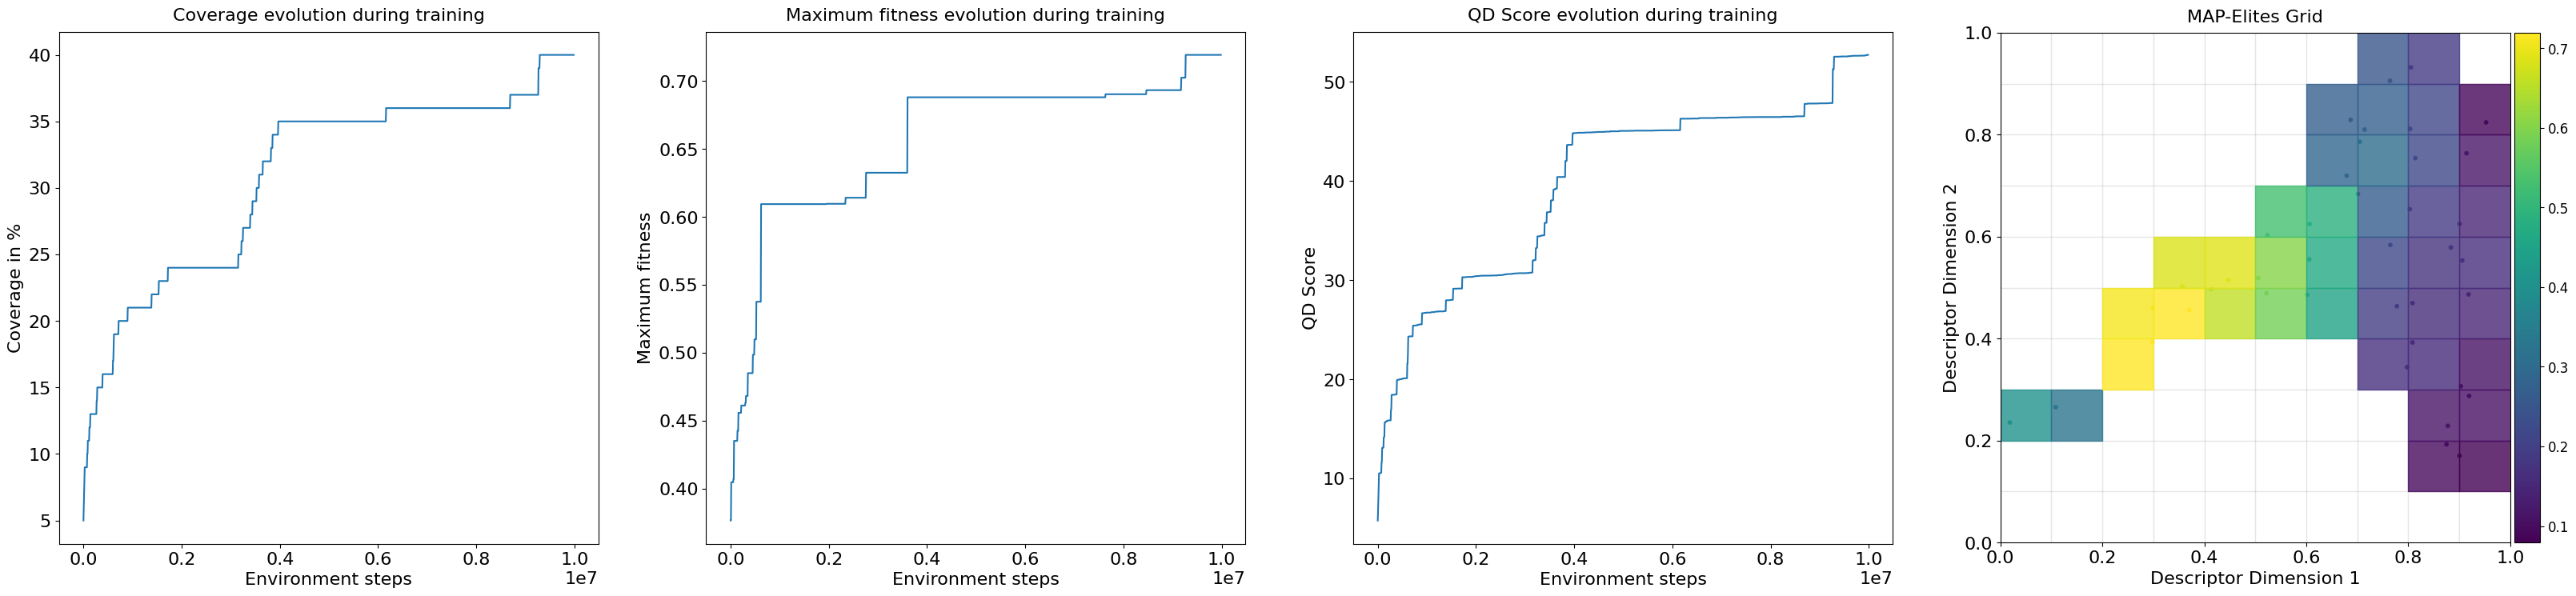

In [17]:
# Create the x-axis array
#env_steps = metrics["iteration"]
env_steps = metrics["iteration"] * batch_size * episode_length * config["NUM_ENVS"]
#print(jnp.max(metrics["iteration"]))

%matplotlib inline
# Create the plots and the grid
fig, axes = plot_map_elites_results(env_steps=env_steps, metrics=metrics, repertoire=repertoire, min_descriptor=min_descriptor, max_descriptor=max_descriptor)

In [18]:
best_idx = jnp.argmax(repertoire.fitnesses)
best_fitness = jnp.max(repertoire.fitnesses)
best_descriptor = repertoire.descriptors[best_idx]
print(
    f"Best fitness in the repertoire: {best_fitness:.2f}\n",
    f"Descriptor of the best individual in the repertoire: {best_descriptor}\n",
    f"Index in the repertoire of this individual: {best_idx}\n"
)

Best fitness in the repertoire: 0.72
 Descriptor of the best individual in the repertoire: [0.29787233 0.3933386 ]
 Index in the repertoire of this individual: 32



In [19]:
# select the parameters of the best individual
my_params = jax.tree.map(
    lambda x: x[best_idx],
    repertoire.genotypes
)

In [20]:
def preprocess_obs_with_id(obs_dict, env):
    """Simulate CTRolloutManager's preprocessing by adding one-hot agent IDs."""
    new_obs_dict = {}
    num_agents = len(env.agents)
    for i, agent in enumerate(env.agents):
        obs = obs_dict[agent].flatten()
        one_hot = jax.nn.one_hot(i, num_classes=num_agents)
        new_obs_dict[agent] = jnp.concatenate([obs, one_hot])
    return new_obs_dict

In [21]:
# Set up environment
#scenario = map_name_to_scenario(config["MAP_NAME"])
env = HeuristicEnemySMAX(scenario=scenario, **config["ENV_KWARGS"])
env = SMAXLogWrapper(env)
#jit_env_reset = jax.jit(env.reset)
#jit_env_step = jax.jit(env.step)
#jit_inference_fn = jax.jit(policy_network.apply)

def visualize_recurrent_policy(trained_params, env, config):
    rng = jax.random.PRNGKey(config["SEED"])
    rng, reset_rng = jax.random.split(rng)
    #wrapped_env = CTRolloutManager(env, batch_size=1)

    # Create policy network
    #network = RNNQNetwork(
    #    action_dim=wrapped_env.max_action_space,
    #    hidden_dim=config["HIDDEN_SIZE"],
    #)
    network = RNNQNetwork(
        action_dim=env.action_space(env.agents[0]).n,
        hidden_dim=config["HIDDEN_SIZE"],
    )
    
    # Reset environment
    #obs, env_state = wrapped_env.batch_reset(reset_rng)
    obs, env_state = env.reset(reset_rng)
    #dones = {
    #    agent: jnp.zeros((1), dtype=bool)
    #    for agent in env.agents + ["__all__"]
    #}
    dones = {agent: jnp.array(False) for agent in env.agents}
    hstate = ScannedRNN.initialize_carry(
        config["HIDDEN_SIZE"], len(env.agents), 1
    )
    
    # Collect all environment states
    returns = {agent: 0.0 for agent in env.agents}
    state_seq = []
    max_steps = config["NUM_STEPS"]

    for step in range(max_steps):
        # Compute Q-values
        # Prepare inputs for network
        obs = preprocess_obs_with_id(obs, env)
        _obs = batchify(obs)         # (num_agents, obs_dim)
        _obs = _obs[:, None, :]                      # (num_agents, 1, obs_dim)

        #_dones = batchify(dones)    # (num_agents,)
        #_dones = _dones[:, None]                     # (num_agents, 1)
        _dones = jnp.stack([jnp.array([dones[agent]]) for agent in env.agents])  # shape (num_agents, 1)
        _dones = jnp.expand_dims(_dones, axis=-1)  # from (3, 1) to (3, 1, 1)

        #print("_obs.shape:", _obs.shape)
        #print("_dones.shape:", _dones.shape)
        #print("hstate.shape:", hstate.shape)

        def apply_fn(h, o, d):
            return network.apply(trained_params, h, o, d)

        hstate, q_vals = jax.vmap(apply_fn, in_axes=(0, 0, 0))(
            hstate,
            _obs,
            _dones,
        )
        #hstate = hstate[:, None, :]  # Already in (num_agents, hidden_dim)
        q_vals = q_vals.squeeze(axis=1)  # (num_agents, num_envs, num_actions) remove the time dim
        #print("q_vals.shape", q_vals.shape)
        
        actions = {}
        #avail_actions = wrapped_env.get_valid_actions(env_state.env_state)
        avail_actions = env.get_avail_actions(env_state.env_state)

        for i, agent in enumerate(env.agents):
            avail_agent = avail_actions[agent][None, None, :]  # shape (1, 1, n_actions)
            #print("avail_agent.shape", avail_agent.shape)
            
            unavail_actions = 1 - avail_agent  # shape (1, 1, n_actions)
            
            # Select Q-values for this agent only
            q_agent = q_vals[i][None, None, :]  # shape (1, 1, n_actions)
            q_masked = q_agent - (unavail_actions * 1e10)

            action = jnp.argmax(q_masked, axis=-1)  # shape (1, 1)
            action = action.squeeze()               # scalar
            #print("action.shape", action.shape)

            # Wrap in array with batch dim
            actions[agent] = int(action)    # shape (1,)
        
        rng, rng_s = jax.random.split(rng)
        state_seq.append((rng_s, env_state.env_state, actions))

        # Step environment

        # Batch the actions dict
        # Original actions: {'ally_0': 4, 'ally_1': 4, 'ally_2': 4}
        #actions = {k: jnp.array([v]) for k, v in actions.items()}

        #obs, env_state, rewards, dones, infos = wrapped_env.batch_step(
        #    rng_s, env_state, actions
        #)
        obs, env_state, rewards, dones, infos = env.step(rng_s, env_state, actions)
        returns = {a: returns[a] + rewards[a] for a in env.agents}
        
        if dones["__all__"]:
            break

    # Visualization
    print("Returns:", returns)

    viz = SMAXVisualizer(env, state_seq)
    viz.animate(view=False, save_fname="MAP-Elites.gif")

In [22]:
#visualize_recurrent_policy(my_params, env, config)